# 01.112 Machine Learning - Project
**Gede Ria Ghosalya - 1001841**

_Part II_
+ Write a function that estimates the emission parameters from the training set using MLE.

In [1]:
#reading file

def read_labeled_file(filename):
    result = []
    singletweet = []
    with open(filename, "r") as f:
        for line in f:
            if line == "\n":
                result.append(singletweet)
                singletweet = []
            else:
                singletweet.append(tuple(line.strip("\n").split(" ")))
    return result
            
# data = read_labeled_file("EN/train")
# print(data)

In [2]:
def estimate_emission_param(data):
    label_to_word_count = {}
    word_count = {}
    label_count = {}
    
    for tweet in data:
        for labeled_word in tweet:
            if labeled_word[0] in word_count:
                word_count[labeled_word[0]] += 1
            else:
                word_count[labeled_word[0]] = 1
                
            if labeled_word[1] in label_count:
                label_count[labeled_word[1]] += 1
            else:
                label_count[labeled_word[1]] = 1
                
            if labeled_word in label_to_word_count:
                label_to_word_count[labeled_word] += 1
            else:
                label_to_word_count[labeled_word] = 1
                
    emission_parameter = {k: label_to_word_count[k]/label_count[k[1]] 
                          for k in label_to_word_count}
    
    return word_count.keys(), label_count.keys(), emission_parameter

# words, labels, param = estimate_emission_param(data)
# print(param)

+  One problem with estimating the emission parameters is that some words that appear in the
test set do not appear in the training set. One simple idea to handle this issue is as follows. First,
replace those words that appear less than k times in the training set with a special token #UNK#
before training. This leads to a “modified training set”. We then use such a modified training set to
train our model.
During the testing phase, if the word does not appear in the “modified training set”, we replace that
word with #UNK# as well.
Set k to 3, implement this fix into your function for computing the emission parameters.

In [3]:
def supress_infrequent_words(data, k=3):
    wordcount = {}
    
    #get word count
    for tweet in data:
        for labeled_word in tweet:
            word = labeled_word[0]
            if word in wordcount:
                wordcount[word] += 1
            else:
                wordcount[word] = 1
                
    #generate new list
    result = []
    newtweet = []
    for tweet in data:
        for labeled_word in tweet:
            word = labeled_word[0]
            if wordcount[word] > k:
                newtweet.append(labeled_word)
            else:
                label = labeled_word[1]
                newtweet.append(("#UNK#",label))
        result.append(newtweet)
        newtweet = []
        
    return result

# sdata = supress_infrequent_words(data)
# words, labels, em_param = estimate_emission_param(sdata)
# print(em_param)

+ Implement a simple sentiment analysis system that produces the tag for each word x in the sequence.
For all the four datasets EN, FR, CN, and SG, learn these parameters with train, and evaluate your
system on the development set dev.in for each of the dataset. Write your output to dev.p2.out
for the four datasets respectively. Compare your outputs and the gold-standard outputs in dev.out
and report the precision, recall and F scores of such a baseline system for each dataset.

In [4]:
def single_sentiment_analysis(labels, param, word):
    mle = (word, "O") #assuming label O for undiscovered word
    mle_value = 0
    for l in labels:
        if (word, l) in param:
            if param[(word, l)] > mle_value:
                mle = (word, l)
                mle_value = param[(word, l)]
    return mle


def write_simple_prediction(country, part, words, labels, param):
    input_filename = country + "/dev.in"
    output_filename = country + "/dev.p"+part+".out"
    with open(input_filename, "r") as inputfile:
        with open(output_filename, "w") as outputfile:
            for line in inputfile:
                if line.strip("\n") in words:
                    pred = single_sentiment_analysis(labels, param, line.strip("\n"))
                    outputfile.write(" ".join(pred)+"\n")
                else:
                    outputfile.write("#UNK# O\n")

# write_simple_prediction("EN","2",
#                         words, labels, em_param)

In [5]:
from datetime import datetime

for c in ["CN", "EN", "SG", "FR"]:
    start = datetime.now()
    data = read_labeled_file(c+"/train")
    sdata = supress_infrequent_words(data)
    words, labels, em_param = estimate_emission_param(sdata)
    write_simple_prediction(c,"2",
                    words, labels, em_param)
    end = datetime.now()
    delt = end - start
    print("{} part 2 done in {}.{}s"\
          .format(c, delt.seconds, delt.microseconds))

CN part 2 done in 0.171915s
EN part 2 done in 0.79357s
SG part 2 done in 0.310790s
FR part 2 done in 0.85036s


_Part III_

+ Write a function that estimates the transition parameters from the training set using MLE

In [6]:
def estimate_transition_parameter(data):
    y0 = "START"
    yn = "STOP"
    label_to_label_count = {}
    label_count = {y0: 0, yn: 0}
    for tweet in data:
        aptweet = tweet + [yn]
        for i in range(len(aptweet)):
            label = aptweet[i][1]
            if label in label_count:
                label_count[label] += 1
            else:
                label_count[label] = 1
                
            if i == 0:
                label_count[y0] += 1
                labelt = (y0, label)
            else:
                prevlabel = aptweet[i-1][1]
                labelt = (prevlabel, label)
            
            if labelt in label_to_label_count:
                label_to_label_count[labelt] += 1
            else:
                label_to_label_count[labelt] = 1
    estimated_param = {k: label_to_label_count[k]/label_count[k[0]]
                       for k in label_to_label_count}
    return estimated_param

# trans_param = estimate_transition_parameter(sdata)
# print(trans_param)

+ Use the estimated transition and emission parameters, implement the Viterbi algorithm. For all datasets, learn the model parameters with train. Run the Viterbi algorithm on the development
set dev.in using the learned models, write your output to dev.p3.out for the four datasets
respectively. Report the precision, recall and F scores of all systems.

In [7]:
# list of dictionary 
#   a dictionary consists of
#    stage = int (stage 0, 1, 2 etc)
#    cur_label = current state (X,Y etc)
#    path = path up to this label (eg [START, X, Y])
#    probability = float (0.23)
        
def predict_tag_sequence(word_sequence, 
                         labels,trans_param,em_param):
    pi_dp = {(0, "START"):1}
    labels = list(labels)
    labels.append("START")
    
    def viterbi_pi(stage, tag, word_sequence,
                   labels, trans_param, em_param):
        if stage == 0:
            result = 1.0 if tag == "START" else 0.0
            return result
        elif stage >= len(word_sequence)+1:
            max_weight = 0
            for prev_tag in labels:
                prev_cost = viterbi_pi(stage-1, prev_tag, word_sequence,
                                      labels, trans_param, em_param)
                trans_prob = trans_param[(prev_tag, tag)]
                curr_weight = prev_cost*trans_prob
                if max_weight < curr_weight:
                    max_weight = curr_weight
            pi_dp[(stage, tag)] = max_weight
            return max_weight
        else:
            if (stage, tag) in pi_dp:
                return pi_dp[(stage, tag)]
            else:
                max_weight = 0
                for prev_tag in labels:
                    prev_cost = viterbi_pi(stage-1, prev_tag, word_sequence,
                                          labels, trans_param, em_param)
                    if (prev_tag, tag) in trans_param:
                        trans_prob = trans_param[(prev_tag, tag)]
                    else:
                        trans_prob = 0
                    word = word_sequence[stage-1]
                    if (word, tag) in em_param:
                        em_prob = em_param[(word, tag)]
                    else:
                        em_prob = 0
                    curr_weight = prev_cost*trans_prob*em_prob
                    if max_weight < curr_weight:
                        max_weight = curr_weight
                pi_dp[(stage, tag)] = max_weight
                return max_weight

    
    for i in range(len(word_sequence)):
        for t in labels:
            viterbi_pi(i, t, word_sequence, 
                       labels, trans_param, em_param)
    
    tag_seqr = ["STOP"]
    
    lenw = len(word_sequence)
    for i in range(lenw+1):
        if i == lenw:
            tag_seqr.append("START")
            continue
        if "none" in labels:
            max_tag = "none"
        else:
            max_tag = "O"
        max_weight = 0
        for tag in labels:
            prev_prob = viterbi_pi(lenw-i, tag, word_sequence,
                                   labels, trans_param, em_param)
            next_tag = tag_seqr[-1]
            if (tag, next_tag) in trans_param:
                trans_prob = trans_param[(tag, next_tag)]
            else:
                trans_prob = 0
            curr_weight = prev_prob*trans_prob
            if max_weight < curr_weight:
                max_weight = curr_weight
                max_tag = tag
        tag_seqr.append(max_tag)
    return tag_seqr[::-1]


# word_sequence = ["we","like","the","ambience"]
# print(predict_tag_sequence(word_sequence))
# print(pi_dp)

In [8]:
def write_hmm_prediction(country, part, prediction_function,
                         words, labels, em_param, trans_param):
    input_filename = country + "/dev.in"
    output_filename = country + "/dev.p"+part+".out"
    indata = []
    with open(input_filename, "r") as infile:
        indata = infile.read().strip('\n').split('\n\n') #read and separate tweets
    
    with open(output_filename, "w") as outfile:
        for tweet in indata:
            word_sequence = tweet.split('\n')
            predicted_tag = prediction_function(word_sequence, labels, trans_param, em_param)
            predicted_tag.remove("START")
            predicted_tag.remove("STOP")
            if len(word_sequence) != len(predicted_tag):
                print("WARNING!! Different length {} / {}"\
                      .format(word_sequence, tag_sequence))
            for i in range(len(word_sequence)):
                line = "{} {}\n".format(word_sequence[i], predicted_tag[i])
                outfile.write(line)
            outfile.write("\n")


for c in ["CN", "EN", "SG", "FR"]:
    start = datetime.now()
    data = read_labeled_file(c+"/train")
    sdata = supress_infrequent_words(data)
    words, labels, em_param = estimate_emission_param(sdata)
    trans_param = estimate_transition_parameter(sdata)
    write_hmm_prediction(c,"3", predict_tag_sequence,
                        words, labels, em_param, trans_param)
    end = datetime.now()
    delt = end - start
    print("{} part 3 done in {}.{}s"\
          .format(c, delt.seconds, delt.microseconds))

CN part 3 done in 0.708952s
EN part 3 done in 0.393983s
SG part 3 done in 2.262295s
FR part 3 done in 0.343450s


 Part IV

+ Use the estimated transition and emission parameters, implement the alternative max-marginal decoding algorithm. Clearly describe the steps of your algorithm in your report.

In [9]:
# alphas = {}

def alpha_forward(tag, stage, word_sequence, alphas,
                  trans_param=trans_param,
                  labels=labels,
                  em_param=em_param):
    '''
    Forward algorithm
    '''
    if stage <= 1:
        if ("START", tag) in trans_param:
            score = trans_param[("START", tag)]
        else:
            score = 0
        alphas[(tag, stage)] = score
        return score
    else:
        if (tag, stage) in alphas:
            return alphas[(tag, stage)]
        score = 0
        for t in labels:
            prev_score = alpha_forward(t, stage-1, word_sequence, alphas)
            if (t, tag) in trans_param:
                trans_prob = trans_param[(t, tag)]
            else:
                trans_prob = 0
            word = word_sequence[stage-2]
            if (word, t) in em_param:
                em_prob = em_param[(word, t)]
            else:
                em_prob = 0
            curr_score = prev_score*trans_prob*em_prob
            score += curr_score
        alphas[(tag, stage)] = score
        return score

In [10]:
# betas = {}

def beta_back(tag, stage, word_sequence, betas,
                  trans_param=trans_param,
                  labels=labels,
                  em_param=em_param):
    '''
    Backward algorithm
    '''
    if stage <= 1:
        if (tag, "STOP") in trans_param:
            score = trans_param[(tag, "STOP")]
        else:
            score = 0
        betas[(tag, stage)] = score
        return score
    else:
        if (tag, stage) in betas:
            return betas[(tag, stage)]
        score = 0
        for t in labels:
            prev_score = beta_back(t, stage-1, word_sequence, betas)
            if (tag, t) in trans_param:
                trans_prob = trans_param[(tag, t)]
            else:
                trans_prob = 0
            word = word_sequence[stage-2]
            if (word, tag) in em_param:
                em_prob = em_param[(word, tag)]
            else:
                em_prob = 0
            curr_score = prev_score*trans_prob*em_prob
            score += curr_score
        betas[(tag, stage)] = score
        return score

In [11]:
def predict_tag_sequence_maxmarginal(word_sequence,
                                    labels=labels,
                                    trans_param=trans_param,
                                    em_param=em_param):
    '''
    using max-marginal decoding algorithm
    '''
    alphas = {}
    betas = {}
    
    tag_seqr = ["STOP"]
    
    lenw = len(word_sequence)
    for i in range(lenw):
        max_tag = "O"
        max_weight = 0
        for tag in labels:
            alph = alpha_forward(tag, i, word_sequence, alphas,
                                 labels=labels, em_param=em_param, 
                                 trans_param=trans_param)
            beth = beta_back(tag, i, word_sequence, betas,
                                 labels=labels, em_param=em_param, 
                                 trans_param=trans_param)
            curr_weight = alph*beth
            if curr_weight > max_weight:
                max_weight = curr_weight
                max_tag = tag
        tag_seqr.append(max_tag)
    tag_seqr.append("START")
    return tag_seqr[::-1]

# word_sequence = ["we","like","the","ambience"]
# print(predict_tag_sequence_maxmarginal(word_sequence))

for c in ["EN", "FR"]:
    start = datetime.now()
    data = read_labeled_file(c+"/train")
    sdata = supress_infrequent_words(data)
    words, labels, em_param = estimate_emission_param(sdata)
    write_hmm_prediction(c,"4",
                        predict_tag_sequence_maxmarginal,
                        words, labels, em_param, trans_param)
    end = datetime.now()
    delt = end - start
    print("{} part 4 done in {}.{}s"\
          .format(c, delt.seconds, delt.microseconds))

EN part 4 done in 0.385215s
FR part 4 done in 0.350346s


Part V

Now, based on the training and development set, think of a better design for developing an
improved sentiment analysis system for tweets using any model you like. Please explain clearly the
method that you used for designing the new system.

In [12]:
'''
Attempt 1: Using dual-tagged HMM

There is some rule to the tagging that is not
covered by the HMM alone, specifically sentiment
vs identity. For example, B-positive cannot be
followed by I-negative. 

Hence, one tag class is sentiment, [positive, negative, neutral, none]
and another  is identity [O, B, I]
before the observation layer
'''

# first of all, we want to generate
# properly-layered file

def split_tag_layer(input_filename, output_filename):
    with open(input_filename, "r") as infile:
        with open(output_filename, "w") as outfile:
            for inline in infile:
                if inline == "\n":
                    outfile.write(inline)
                    continue
                    
                line = inline.strip("\n").split(" ")
                if len(line) < 2:
                    pass
                elif "positive" in line[1]:
                    line[1] = line[1][0]
                    line.append("positive")
                elif "negative" in line[1]:
                    line[1] = line[1][0]
                    line.append("negative")
                elif "neutral" in line[1]:
                    line[1] = line[1][0]
                    line.append("neutral")
                else:
                    line.append("none")
                
                string = " ".join(line) + "\n"
                outfile.write(string)
                
split_tag_layer("EN/train", "EN/trainl")

In [13]:
'''
Now that the file is tagged properly,
we can generate estimated parameters

Note that while the identity tags [O, B, I] are ordered,
sentiments are not - they are not always associated with 
the identified phares
'''

def read_splitlabel_file(filename):
    sm_emparam = []
    sm_tweet = []
    id_emparam = []
    id_tweet = []
    with open(filename, "r") as f:
        for line in f:
            if line == "\n":
                id_emparam.append(id_tweet)
                id_tweet = []
                sm_emparam.append(sm_tweet)
                sm_tweet = []
            else:
                linetags = line.strip("\n").split(" ")
                id_tweet.append(tuple([linetags[0], linetags[1]]))
                sm_tweet.append(tuple([linetags[0], linetags[2]]))
    return sm_emparam, id_emparam

sm_data, id_data = read_splitlabel_file("EN/trainl")
# print(sm_param)
# print(id_param)

In [14]:
'''
Once data is extracted, we can estimate
identity (and sentiment) tags with normal HMM methods
'''

words, labels, id_emparam = estimate_emission_param(id_data)
id_transparam = estimate_transition_parameter(id_data)
swords, slabels, sm_emparam = estimate_emission_param(sm_data)
sm_transparam = estimate_transition_parameter(sm_data)

def predict_dualtag_sequence(word_sequence, labels, slabels,
                            id_emparam, id_transparam,
                            sm_emparam, sm_transparam):
    id_tagsequence = predict_tag_sequence(word_sequence, labels,
                                          id_transparam, id_emparam)
    sm_tagsequence = predict_tag_sequence(word_sequence, slabels,
                                          sm_transparam, sm_emparam)
    # we do some cleanup
    # because in the original, only identities have sentiments
    # but the prediction might not be the case
    sm_count = {}
    for sm in sm_tagsequence:
        sm_count[sm] = sm_count.get(sm, 0) + 1
        
    if "none" in sm_count:
        del sm_count["none"]
    if "START" in sm_count:
        del sm_count["START"]
    if "STOP" in sm_count:
        del sm_count["STOP"]
        
    mostcommon = ("neutral", 0)
    for sm in sm_count:
        if sm_count[sm] > mostcommon[1]:
            mostcommon = (sm, sm_count[sm])
    
    for i in range(len(id_tagsequence)):
        if id_tagsequence[i] != "O" and sm_tagsequence[i] == "none":
#             print(" ".join(word_sequence) + " is problematic..")
#             print("adding default "+mostcommon[0])
            sm_tagsequence[i] = mostcommon[0]
    
    return id_tagsequence, sm_tagsequence

word_sequence = ["we", "like", "the", "ambience"]
id_tagseq, sm_tagseq = predict_dualtag_sequence(word_sequence, labels, slabels,
                                               id_emparam, id_transparam,
                                               sm_emparam, sm_transparam)
print(id_tagseq)
print(sm_tagseq)


['START', 'O', 'O', 'O', 'O', 'STOP']
['START', 'none', 'none', 'none', 'none', 'STOP']


In [15]:
'''
Now, we can write the predictions
'''
def write_dualhmm_prediction(country, part, prediction_function,
                             words, labels, slabels,
                             id_emparam, id_transparam,
                             sm_emparam, sm_transparam):
    input_filename = country + "/dev.in"
    output_filename = country + "/dev.p"+part+".out"
    indata = []
    with open(input_filename, "r") as infile:
        indata = infile.read().strip('\n').split('\n\n') #read and separate tweets
    
    with open(output_filename, "w") as outfile:
        for tweet in indata:
            word_sequence = tweet.split('\n')
            pred_id_tag, pred_sm_tag = prediction_function(word_sequence, labels, slabels,
                                                id_emparam, id_transparam,
                                                sm_emparam, sm_transparam)
            pred_id_tag.remove("START")
            pred_id_tag.remove("STOP")
            pred_sm_tag.remove("START")
            pred_sm_tag.remove("STOP")
            if len(word_sequence) != len(pred_id_tag):
                print("WARNING!! Different length \n{} / \n{}"\
                      .format(word_sequence, pred_id_tag))
            for i in range(len(word_sequence)):
                line = "{} {} {}\n".format(word_sequence[i], pred_id_tag[i], pred_sm_tag[i])
                outfile.write(line)
            outfile.write("\n")

            
for c in ["CN", "EN", "SG", "FR"]:
    start = datetime.now()
    split_tag_layer(c+"/train", c+"/trainl")
    sm_data, id_data = read_splitlabel_file(c+"/trainl")
    sm_data = supress_infrequent_words(sm_data)
    id_data = supress_infrequent_words(id_data)
    
    words, labels, id_emparam = estimate_emission_param(id_data)
    id_transparam = estimate_transition_parameter(id_data)
    swords, slabels, sm_emparam = estimate_emission_param(sm_data)
    sm_transparam = estimate_transition_parameter(sm_data)
    
    write_dualhmm_prediction(c,"5l", predict_dualtag_sequence,
                             words, labels, slabels,
                             id_emparam, id_transparam,
                             sm_emparam, sm_transparam)
    end = datetime.now()
    delt = end - start
    print("{} part 5 done in {}.{}s"\
          .format(c, delt.seconds, delt.microseconds))

CN part 5 done in 0.818423s
EN part 5 done in 0.433303s
SG part 5 done in 2.865688s
FR part 5 done in 0.444736s


In [16]:
'''
Finally, we convert back the file
to the original format
'''
def merge_tag_layer(input_filename, output_filename):
    with open(input_filename, "r") as infile:
        with open(output_filename, "w") as outfile:
            for inline in infile:
                if inline == "\n":
                    outfile.write("\n")
                    continue
                line = inline.strip("\n").split(" ")
                if line[1] == "O":
                    string = " ".join(line[:-1]) + "\n"
                else:
                    string = " ".join(line[:-1]) + "-"+ line[2] + "\n"
                outfile.write(string)
                
for c in ["CN","EN","SG","FR"]:
    merge_tag_layer(c+"/dev.p5l.out", c+"/dev.p5.out")

In [17]:
'''
Comparing this to part3 (HMM with Viterbi)
 // code taken from EvalScript
'''

import sys
import re
from copy import copy
from collections import defaultdict
from optparse import OptionParser

#Read entities from predcition
def get_predicted(predicted, answers=defaultdict(lambda: defaultdict(defaultdict)),
                  separator=" ",outputColumnIndex=1):

    example = 0
    word_index = 0
    entity = []
    last_ne = "O"
    last_sent = ""
    last_entity = []

    answers[example] = []
    for line in predicted:
        line = line.strip()
        if line.startswith("##"):
            continue
        elif len(line) == 0:
            if entity:
                answers[example].append(list(entity))
                entity = []

            example += 1
            answers[example] = []
            word_index = 0
            last_ne = "O"
            continue
        else:
            split_line = line.split(separator)
            #word = split_line[0]
            value = split_line[outputColumnIndex]
            ne = value[0]
            sent = value[2:]


            last_entity = []

            #check if it is start of entity
            if ne == 'B' or (ne == 'I' and last_ne == 'O') or (last_ne != 'O' and ne == 'I' and last_sent != sent):
                if entity:
                    last_entity = list(entity)

                entity = [sent]
                    
                entity.append(word_index)

            elif ne == 'I':
                entity.append(word_index)

            elif ne == 'O':
                if last_ne == 'B' or last_ne == 'I':
                    last_entity =list(entity)
                entity = []


            if last_entity:
                answers[example].append(list(last_entity))
                last_entity = []

        last_sent = sent
        last_ne = ne
        word_index += 1

    if entity:
        answers[example].append(list(entity))


    return answers



#Read entities from gold data
def get_observed(observed, separator=" ",
                 outputColumnIndex=1):


    example = 0
    word_index = 0
    entity = []
    last_ne = "O"
    last_sent = ""
    last_entity = []

    observations=defaultdict(defaultdict)
    observations[example] = []

    for line in observed:
        line = line.strip()
        if line.startswith("##"):
            continue
        elif len(line) == 0:
            if entity:
                observations[example].append(list(entity))
                entity = []

            example += 1
            observations[example] = []
            word_index = 0
            last_ne = "O"
            continue

        else:
            split_line = line.split(separator)
            word = split_line[0]
            value = split_line[outputColumnIndex]
            ne = value[0]
            sent = value[2:]


            last_entity = []

            #check if it is start of entity, suppose there is no weird case in gold data
            if ne == 'B' or (ne == 'I' and last_ne == 'O') or (last_ne != 'O' and ne == 'I' and last_sent != sent):
                if entity:
                    last_entity = entity

                entity = [sent]
                    
                entity.append(word_index)

            elif ne == 'I':
                entity.append(word_index)

            elif ne == 'O':
                if last_ne == 'B' or last_ne == 'I':
                    last_entity = entity
                entity = []


            if last_entity:
                observations[example].append(list(last_entity))
                last_entity = []


        last_ne = ne
        last_sent = sent
        word_index += 1

    if entity:
        observations[example].append(list(entity))
    return observations

#Compare results bewteen gold data and prediction data
def compare_observed_to_predicted(observed, predicted):

    correct_sentiment = 0
    correct_entity = 0

    total_observed = 0.0
    total_predicted = 0.0

    #For each Instance Index example (example = 0,1,2,3.....)
    for example in observed:
        observed_instance = observed[example]
        predicted_instance = predicted[example]

        #Count number of entities in gold data
        total_observed += len(observed_instance)
        #Count number of entities in prediction data
        total_predicted += len(predicted_instance)

        #For each entity in prediction
        for span in predicted_instance:
            span_begin = span[1]
            span_length = len(span) - 1
            span_ne = (span_begin, span_length)
            span_sent = span[0]

            #For each entity in gold data
            for observed_span in observed_instance:
                begin = observed_span[1]
                length = len(observed_span) - 1
                ne = (begin, length)
                sent = observed_span[0]

                #Entity matched
                if span_ne == ne:
                    correct_entity += 1
                    

                    #Entity & Sentiment both are matched
                    if span_sent == sent:
                        correct_sentiment += 1

    result = []
    result.append(total_observed)
    result.append(total_predicted)
    result.append(correct_entity)
    prec = 100*correct_entity/total_predicted
    rec = 100*correct_entity/total_observed
    result.append(prec) # entity precision
    result.append(rec) # entity recall
    result.append(correct_sentiment)
    prec = 100*correct_sentiment/total_predicted
    rec = 100*correct_sentiment/total_observed
    result.append(prec) # sentiment precision
    result.append(rec) # sentiment recall
    
    return result


[362.0, 102.0, 33, 32.35294117647059, 9.116022099447514, 24, 23.529411764705884, 6.629834254143646]
[362.0, 102.0, 33, 32.35294117647059, 9.116022099447514, 24, 23.529411764705884, 6.629834254143646]


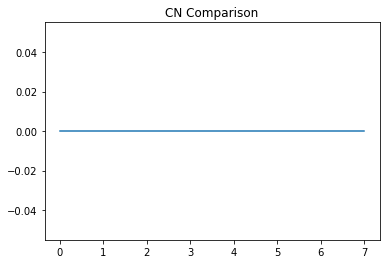

[226.0, 84.0, 67, 79.76190476190476, 29.646017699115045, 40, 47.61904761904762, 17.699115044247787]
[226.0, 84.0, 67, 79.76190476190476, 29.646017699115045, 40, 47.61904761904762, 17.699115044247787]


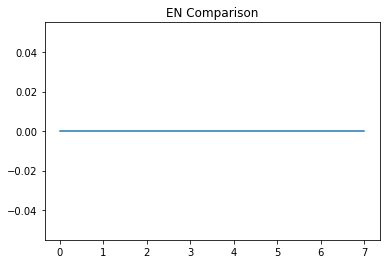

[1382.0, 200.0, 100, 50.0, 7.23589001447178, 71, 35.5, 5.137481910274964]
[1382.0, 200.0, 100, 50.0, 7.23589001447178, 71, 35.5, 5.137481910274964]


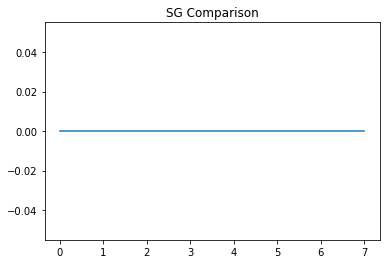

[223.0, 92.0, 73, 79.34782608695652, 32.73542600896861, 37, 40.21739130434783, 16.591928251121075]
[223.0, 92.0, 73, 79.34782608695652, 32.73542600896861, 37, 40.21739130434783, 16.591928251121075]


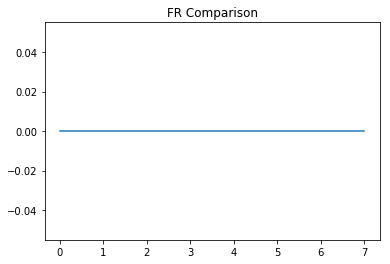

In [20]:
import matplotlib.pyplot as plt

pred_eval = {}

for c in ["CN","EN","SG","FR"]:
    gold = open(c+"/dev.out", "r", encoding='UTF-8')
    observed = get_observed(gold)
    prediction3 = open(c+"/dev.p3.out", "r", encoding='UTF-8')
    predicted3 = get_predicted(prediction3)
    prediction5 = open(c+"/dev.p5.out", "r", encoding='UTF-8')
    predicted5 = get_predicted(prediction5)
    
    resul3 = compare_observed_to_predicted(observed, predicted3)
    print(resul3)
    resul5 = compare_observed_to_predicted(observed, predicted5)
    print(resul5)
    resul_diff = [resul5[i] - resul3[i] for i in range(len(resul3))]
    x3 = [x for x in range(len(resul3))]
#     x5 = [x+0.22 for x in range(len(resul5))]
    width = 1
#     plt.bar(x3, resul3, width, color="blue")
#     plt.bar(x5, resul5, width, color="green")
    plt.title(c+" Comparison")
#     plt.bar(x3, resul_diff)
    plt.plot(resul_diff)
    plt.show()